<a href="https://colab.research.google.com/github/ilanhaskel/Alzheimers_fMRI_Capstone/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain f-MRI Image Classification of Alzheimer's Diagnosis Using Deep Learning Modeling CNNs

## Imports

In [1]:
import random as python_random
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models, regularizers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from numpy.random import seed
seed(72)
tf.random.set_seed(72)
python_random.seed(72)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Exploration

In [4]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/data',
    batch_size=6400,
    seed=42,
    image_size=(256, 256)
)

Found 6400 files belonging to 2 classes.


In [5]:
images, labels = next(iter(data))

In [6]:
images, labels = np.array(images), np.array(labels)

In [7]:
pd.DataFrame(labels).value_counts()

0    3200
1    3200
dtype: int64

In [8]:
dict_labels = {0:'Healthy', 1:'Demented'}

In [9]:
percents = np.round(pd.DataFrame(labels).value_counts(normalize=True).sort_index()*100).values

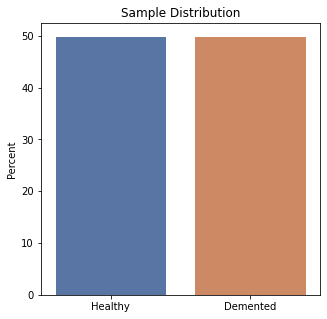

In [10]:
fig, ax = plt.subplots(figsize=(5,5))

sns.set_theme(context='notebook', style='white', font='sans-serif', font_scale = 1)

dist_plot = sns.barplot(x=list(dict_labels.values()), y=percents,ax=ax)
dist_plot.set_title('Sample Distribution')
dist_plot.set_ylabel('Percent');

In [11]:
images.shape

(6400, 256, 256, 3)

In [12]:
labels.shape

(6400,)

## Data Preparation

First, we split the data into a training set, a validation set, and a test set, in order to begin modeling. Next, we normalized the image matrices.

### Train-Test Split

First we performed a train-test split on the entire dataset, using 70% of the total data for model training. On the remaining 30%, a subsequent train-test split was conducted in order to create a validation set and a holdout test both equal to 15% of our total data. These proportions are generally seen as acceptable given the size of our data.

In [13]:
train_images, test_images, train_labels, test_labels = train_test_split(images,
                                                                        labels,
                                                                        test_size=0.3,
                                                                        random_state=42)

In [14]:
test_images, val_images, test_labels, val_labels = train_test_split(test_images,
                                                                    test_labels,
                                                                    random_state=42,
                                                                    test_size=0.5)

Our training set maintains a near-50% class distribution between healthy and demented.

In [15]:
pd.DataFrame(train_labels).value_counts(normalize=True)

1    0.502009
0    0.497991
dtype: float64

### Normalize Image Matrices

Since no upsampling is needed, the next step is to normalize the image matrices. Since our images are 256x256 pixels, we divide the entries by 255 to normalize. This process makes each entry's value, or pixel, between 0 and 1.

In [16]:
train_images, test_images, val_images = train_images/255, test_images/255, val_images/255

## Data Modeling

Before starting the modeling process, we create a function titled ```evaluate``` to visualize the results of each model. This function takes the model, results, and evaluation data, and prints out the following metrics and visualizations: loss for the training and validation sets, AUC for the training and validation sets, accuracy and recall scores for the training and validation sets, and a confusion matrix for the binary classification problem. The function is detailed below.



In [26]:
def evaluate(model, name, history, X, y, threshold=0.5):
    
    print(f"Results for {name} with threshold = {threshold}.")
    
    plt.rcParams.update({'font.size': 18})
    # Create a function that provides useful vis for model
    # performance. This is especially useful as we are most
    # concerned with the number of false negatives
    
    # Variables for loss and AUC for training and validation data
    train_loss=[value for key, value in history.items() if 'loss' in key.lower()][0]
    valid_loss=[value for key, value in history.items() if 'loss' in key.lower()][1]
    train_auc=[value for key, value in history.items() if 'auc' in key.lower()][0]
    valid_auc=[value for key, value in history.items() if 'auc' in key.lower()][1]
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 15))

    # Plotting loss per epoch for training and validation data
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(train_loss, color='tab:blue', label='Train Loss')
    ax1.plot(valid_loss, color='tab:orange', label='Valid Loss')
    ax1.legend(loc='upper left')
    ax1.set_ylim([0,1.05])
    plt.title('Model Loss')

    # Plotting AUC per epoch for training and validation data
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('AUC')
    ax2.plot(train_auc, color='tab:blue', label='Train AUC')
    ax2.plot(valid_auc, color='tab:orange', label='Valid AUC')
    ax2.legend(loc='upper left')
    ax2.set_ylim([0.5,1.05])
    plt.title('Model AUC')
        
    # Grabbing our model predictions for use in confusion matrix
    y_pred = model.predict(X)
    y_pred_adjusted = np.zeros([len(y), ])
    i=0
    for pred in y_pred:
        if pred > threshold:
            y_pred_adjusted[i] = 1
            i+=1
        else:
            y_pred_adjusted[i] = 0
            i+=1

    # Plotting confusion matrix
    cm = confusion_matrix(y, y_pred_adjusted)
    cm_df = pd.DataFrame(cm)

    sns.heatmap(cm, ax=ax3, annot=True, cmap='Blues', fmt='0.7g') 

    plt.sca(ax3)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    
    # Printing recall and accuracy for training and validation data
    train_recall=[value for key, value in history.items() if 'recall' in key.lower()][0]
    valid_recall=[value for key, value in history.items() if 'recall' in key.lower()][1]
    train_accuracy=[value for key, value in history.items() if 'accuracy' in key.lower()][0]
    valid_accuracy=[value for key, value in history.items() if 'accuracy' in key.lower()][1]
    
    print(f"\n Train Accuracy: {train_accuracy[-1]} \n Val Accuracy: {valid_accuracy[-1]} \n\n Train Recall: {train_recall[-1]} \n Val Recall: {valid_recall[-1]}")

    # Plotting recall per epoch for training and validation data
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Recall')
    ax4.set_ylim([-0.05,1.05])
    ax4.plot(train_recall, '--', color='tab:orange', label='Train Recall')
    ax4.plot(valid_recall, color='tab:orange', label='Valid Recall')
    ax4.legend(loc='lower left')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

## First Simple Model

For the first model, I chose to use a sequential model. The input layer is a 2D convolutional layer with a 3x3 convolutional window and a dimensionality of 128. The activation used is relu. The next layer (and first hidden layer) is a 2D max pooling layer which downsaples the input and extracts the features with the highest importance. The inclusion of a pooling layer was necessary for performance reasons, and max pooling was chosen specifically for its tendency to perform better in image classification tasks relative to other pooling methods such as average pooling. A flattening layer is added next to compress the output into a single-dimensional matrix, which is then fed into a dense layer with 512 nodes and a relu activation. A dense layer of this dimensionality may cause overfitting, but this can be addressed in future iterations. Finally, our output layer is a dense layer with a sigmoid activation that will squeeze the outputs between 0 and 1, returning the probability that the input belongs to the positive class (Demented) in our binary classification problem.

In [18]:
# instantiating our input dimensions as a variable for use in the first layer of subsequent models
input_layer = (256,256,3)

In [19]:
model1 = models.Sequential([
    # Conv2D input layer, making sure to specify input shape
    layers.Conv2D(128, (3,3), activation='relu', input_shape=(input_layer)),
    # apply pooling
    layers.MaxPooling2D(2,2),
    # flatten the result to feed it to the dense layer
    layers.Flatten(), 
    # dense layer with 512 neurons for processing the output coming by the previous layers
    layers.Dense(512, activation='relu'),
    # single output neuron with sigmoid activation function
    layers.Dense(1, activation='sigmoid')  
])

In [20]:
# Printing model summary as sanity check for model structure
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 128)    0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2064512)           0         
                                                                 
 dense (Dense)               (None, 512)               1057030656
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1,057,034,753
Trainable params: 1,057,034,753
Non-trainable params: 0
______________________________________

In [21]:
# instantiating list of metrics to be used in model compilation
metrics = ['accuracy', 'AUC', tf.keras.metrics.Recall()]

Before training and evaluating our first model, it must first be compiled. I chose to use `adam` optimization for its computational efficiency and ability to handle large numbers of parameters. `binary_crossentropy` is used for the loss function as it is suitable for binary classification. Accuracy, AUC, and Recall are chosen as evaluation metrics due to their sensitivity towards false negatives and suitability for our business problem. The confusion matrix generated by our `evaluate()` function will also be very useful for evaluation, as it will tell us exactly how many false negatives are present in our model predictions.


In [22]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics)

After compiling, the model is fit to the training data and its history is extracted and stored as a variable for use in our `evaluate()` function. I chose to train the model with 10 epochs, as training and validation loss seem to bottom out around this point. This effect can be seen in the graph generated by our evaluate() function where model training and validation loss are plotted against number of training epochs. A default batch size of 32 is used in training for the purpose of training efficiency and stability of gradient descent.

In [23]:
history1=model1.fit(train_images, 
                  train_labels,
                  epochs=10,
                  validation_data=(val_images,val_labels),
                  verbose=2
                  ).history

Epoch 1/10
140/140 - 21s - loss: 2.5243 - accuracy: 0.6558 - auc: 0.6974 - recall: 0.6501 - val_loss: 0.6137 - val_accuracy: 0.6135 - val_auc: 0.8447 - val_recall: 0.2485 - 21s/epoch - 149ms/step
Epoch 2/10
140/140 - 8s - loss: 0.4111 - accuracy: 0.8174 - auc: 0.8999 - recall: 0.8173 - val_loss: 0.3294 - val_accuracy: 0.8573 - val_auc: 0.9509 - val_recall: 0.7659 - 8s/epoch - 55ms/step
Epoch 3/10
140/140 - 8s - loss: 0.2264 - accuracy: 0.9172 - auc: 0.9739 - recall: 0.9151 - val_loss: 0.2295 - val_accuracy: 0.9083 - val_auc: 0.9699 - val_recall: 0.8912 - 8s/epoch - 55ms/step
Epoch 4/10
140/140 - 8s - loss: 0.0896 - accuracy: 0.9754 - auc: 0.9971 - recall: 0.9733 - val_loss: 0.1346 - val_accuracy: 0.9500 - val_auc: 0.9887 - val_recall: 0.9405 - 8s/epoch - 54ms/step
Epoch 5/10
140/140 - 8s - loss: 0.0397 - accuracy: 0.9940 - auc: 0.9998 - recall: 0.9938 - val_loss: 0.1527 - val_accuracy: 0.9365 - val_auc: 0.9939 - val_recall: 0.8871 - 8s/epoch - 55ms/step
Epoch 6/10
140/140 - 8s - loss: 

In [31]:
# saving model off for economy of processing power
# commenting out as a user looking to reproduce this notebook will be able to load model from github repository

# model1.save('/content/drive/My Drive/alz_models/model1')

## First Simple Model - Evaluation

In [33]:
# loading model from file path
# for notebook reproduction user will need to replace file path with './models/model1'
model1 = models.load_model('/content/drive/My Drive/alz_models/model1')

Results for model1 with threshold = 0.5.
30/30 [==============================] - 0s 13ms/step

 Train Accuracy: 1.0 
 Val Accuracy: 0.9822916388511658 

 Train Recall: 1.0 
 Val Recall: 0.987679660320282


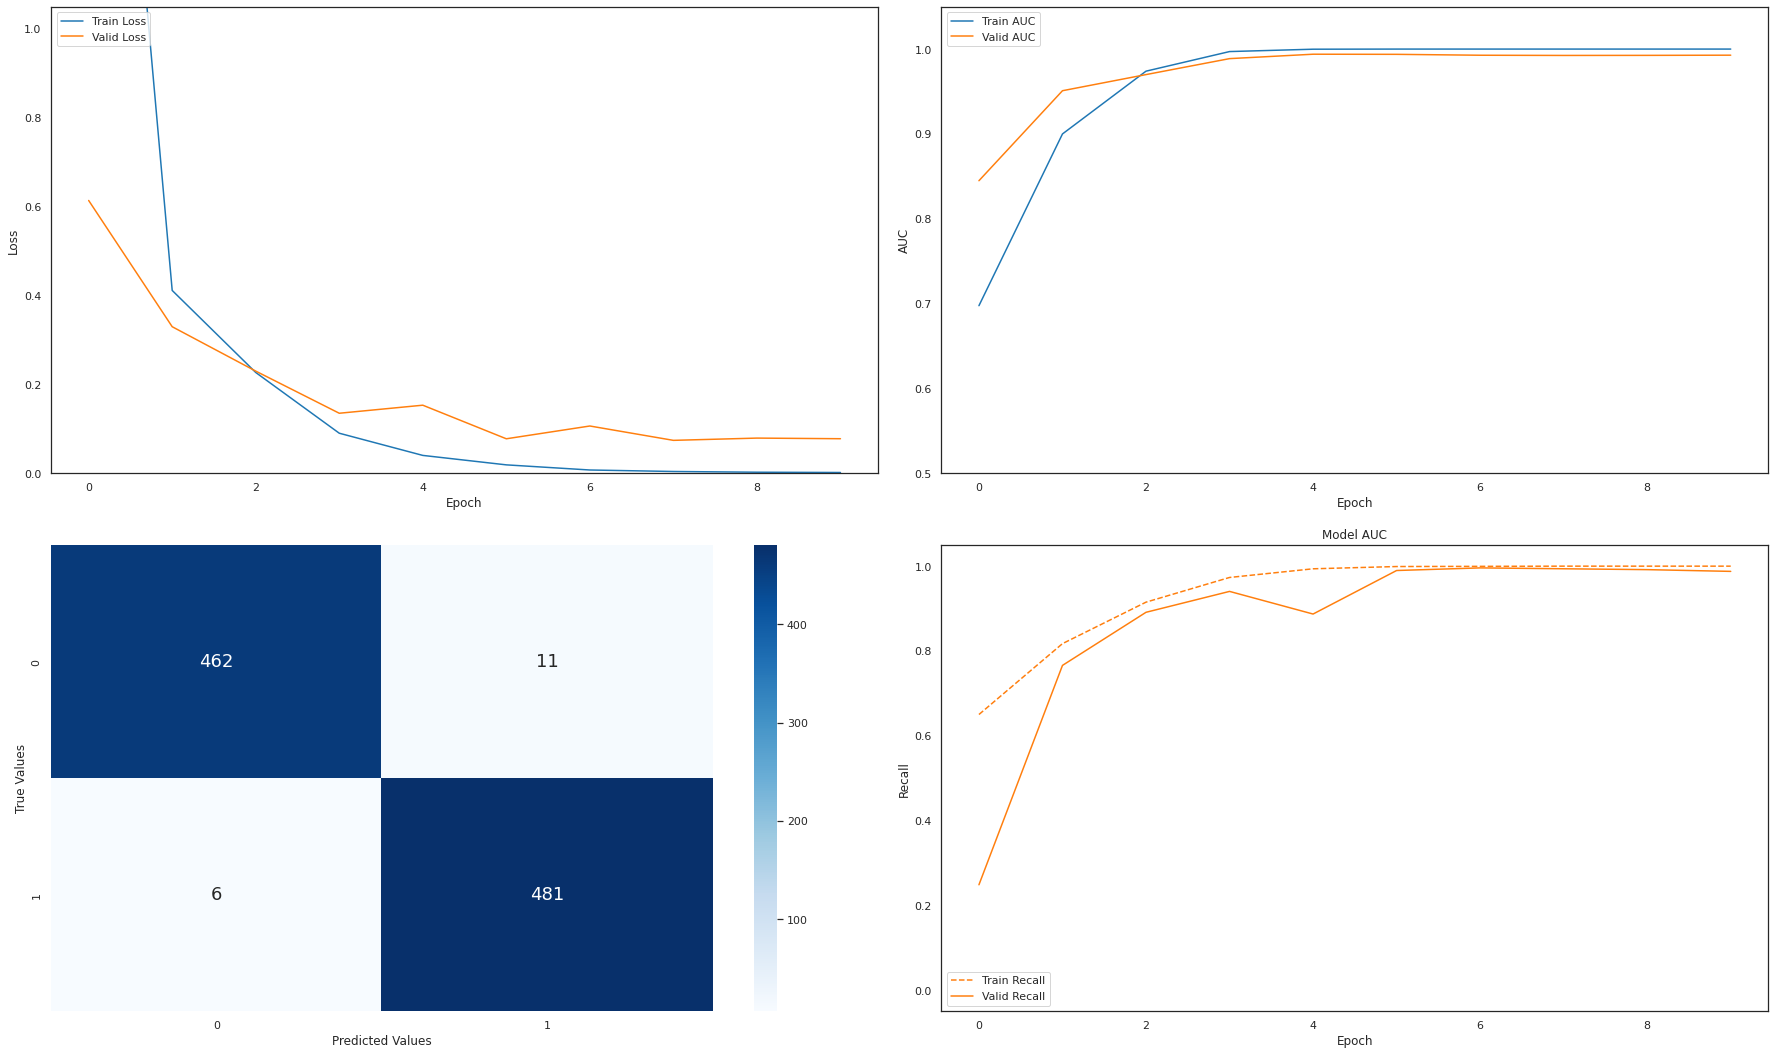

In [36]:
# using our evaluate function
evaluate(model1, 'model1', history1, X=val_images, y=val_labels, threshold=0.5)

We can see from the above performance metrics and visualizations that this first 'simple' model is already performing remarkably well. When evaluated on validation data, this first model yields an accuracy score of ~98.23%, a recall score of ~98.77%, and an AUC of ~0.9928, all of which approach the upper bounds of CNN performance. Furthermore, our confusion matrix shows that our model predictions yielded only 6 false negatives out of the 960 predictions made on validation data.

## Second Model Iteration


Adding dropout layer to address slight overfitting

In [15]:
model2 = models.Sequential([
    # since Conv2D is the first layer of the neural network, we should also specify the size of the input
    layers.Conv2D(128, (3,3), activation='relu', input_shape=(input_layer)),
    # apply pooling
    layers.MaxPooling2D(2,2),
    # flatten the result to feed it to the dense layer
    layers.Flatten(), 
    # and define 512 neurons for processing the output coming by the previous layers
    layers.Dense(512, activation='relu'),
    # dropout layer
    layers.Dropout(0.5),
    # a single output neuron
    layers.Dense(1, activation='sigmoid')  
])

In [16]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 128)    0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2064512)           0         
                                                                 
 dense (Dense)               (None, 512)               1057030656
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                        

In [21]:
metrics

['accuracy',
 'AUC',

In [17]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics)

In [18]:
history2=model2.fit(train_images, 
                  train_labels,
                  epochs=10,
                  validation_data=(val_images,val_labels),
                  verbose=2
                  ).history

Epoch 1/10
140/140 - 21s - loss: 3.5704 - accuracy: 0.5938 - auc: 0.6216 - recall: 0.5949 - precision: 0.5955 - val_loss: 0.5577 - val_accuracy: 0.7302 - val_auc: 0.8184 - val_recall: 0.7906 - val_precision: 0.7103 - 21s/epoch - 152ms/step
Epoch 2/10
140/140 - 8s - loss: 0.4117 - accuracy: 0.8161 - auc: 0.8980 - recall: 0.8110 - precision: 0.8205 - val_loss: 0.3308 - val_accuracy: 0.8646 - val_auc: 0.9409 - val_recall: 0.8932 - val_precision: 0.8480 - 8s/epoch - 55ms/step
Epoch 3/10
140/140 - 8s - loss: 0.2211 - accuracy: 0.9208 - auc: 0.9745 - recall: 0.9226 - precision: 0.9198 - val_loss: 0.2235 - val_accuracy: 0.9156 - val_auc: 0.9718 - val_recall: 0.8953 - val_precision: 0.9356 - 8s/epoch - 55ms/step
Epoch 4/10
140/140 - 8s - loss: 0.1074 - accuracy: 0.9661 - auc: 0.9946 - recall: 0.9649 - precision: 0.9675 - val_loss: 0.1483 - val_accuracy: 0.9521 - val_auc: 0.9879 - val_recall: 0.9692 - val_precision: 0.9384 - 8s/epoch - 55ms/step
Epoch 5/10
140/140 - 8s - loss: 0.0523 - accuracy

Results for model2 with threshold = 0.5.
30/30 [==============================] - 0s 13ms/step

 Train f1: 0.9977758042534552 
 Val f1: 0.9816700441825859 

 Train Recall: 0.9973321557044983 
 Val Recall: 0.9897330403327942


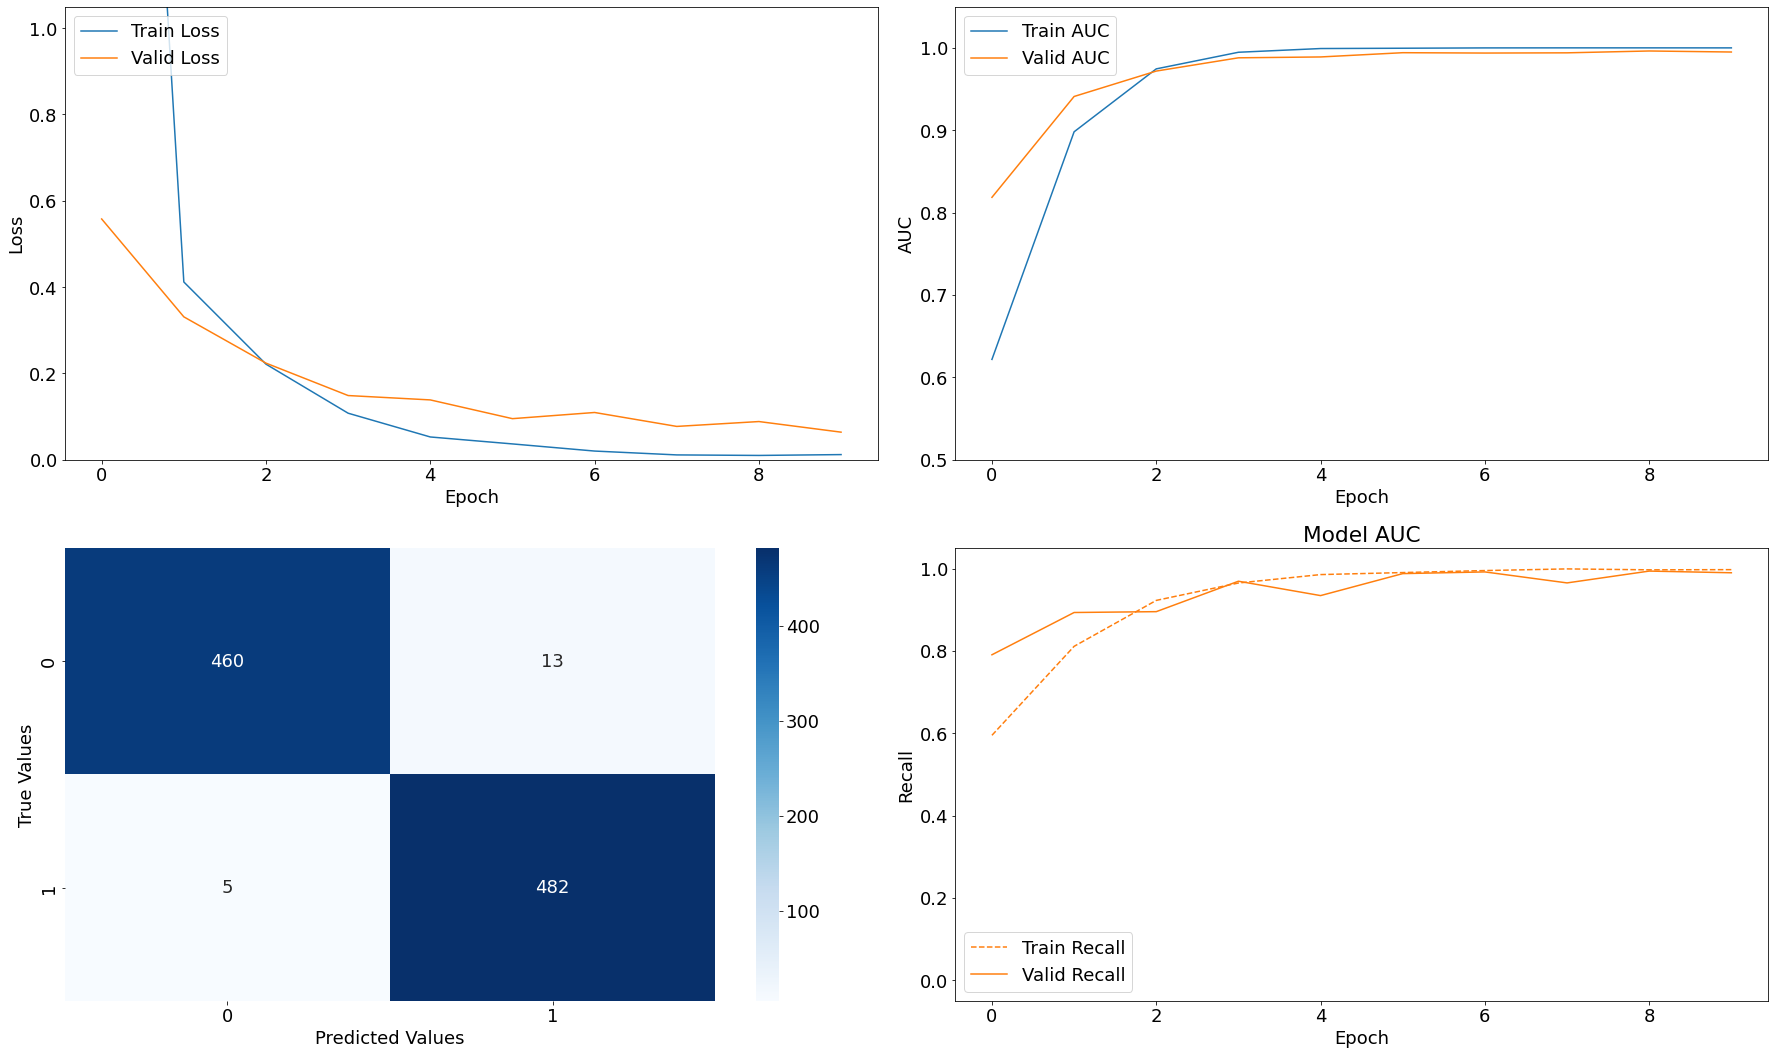

In [19]:
evaluate(model2, 'model2', history2, X=val_images, y=val_labels, threshold=0.5)